In [8]:
import pandas as pd
import pandas_profiling
import numpy as np
import os
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from patsy import dmatrices
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from tableone import TableOne
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, BayesianRidge
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_validate, train_test_split, cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_predict
import pickle
from model_utils import model_fit, gen_ci, evaluate_model

from xgboost import XGBClassifier
import warnings
warnings.simplefilter(action='ignore')
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
cdiff_dir = "/data/CDAI/"

In [10]:
# features = ['age', 'gender', 
#             'comobidities', 
# #             'ckd', 'cih', 'arf', 'diabetes', 
# #              'cardiop_disease', 'liver_disease', 'ibd', 'malignancy',
#             'aniongap', 'albumin', 'bicarbonate', 'bilirubin', 
#             'creatinine', 'chloride', 'glucose_lab', 'hematocrit', 'hemoglobin',
#             'lactate', 'platelet', 'potassium', 'ptt', 'inr', 'pt', 
#             'sodium', 'bun', 'wbc', 'calcium_1st', 'freecalcium_1st', 'heartrate', 
#             'resprate', 'spo2', 'tempc', 'sysbp', 'diasbp', 'meanbp']

features = ['age', 'gender', 'aniongap', 'albumin', 'bicarbonate', 'bilirubin',
       'creatinine', 'chloride', 'glucose_lab', 'hematocrit', 'hemoglobin',
       'lactate', 'platelet', 'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun',
       'wbc', 'calcium_1st', 'freecalcium_1st', 'heartrate', 'resprate',
       'spo2', 'tempc', 'sysbp', 'diasbp', 'meanbp']

In [11]:
# fullX_train.columns

In [12]:
len(features)

29

In [13]:
# print(fullX_train.shape)
# print(fully_train.shape)
# print(fullX_test.shape)
# print(fully_test.shape)

In [14]:
fitted_models = []
cali_models = []
pred_scores = []
labels = []
preds = []
accs = []
aucs = []
sens = []
specs = []
ppvs = []
npvs = []
thresholds = []
for r_seed in range(100):
    fullX_train = pd.read_csv(os.path.join(cdiff_dir, "fullX_train_"+str(r_seed)+".csv"))[features]
    fully_train = pd.read_csv(os.path.join(cdiff_dir, "./fully_train_"+str(r_seed)+".csv"), header=None)
    fullX_test = pd.read_csv(os.path.join(cdiff_dir, "./fullX_test_"+str(r_seed)+".csv"))[features]
    fully_test = pd.read_csv(os.path.join(cdiff_dir, "./fully_test_"+str(r_seed)+".csv"), header=None)
    
    logit_model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                 intercept_scaling=1, l1_ratio=None, max_iter=1000,
                                 multi_class='auto', n_jobs=16, penalty='l2',
                                 random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                                 warm_start=False)
    fitted_model, cali_model, y_test, y_prob, \
    decision, acc, auc, sensitivity, \
    specificity, pos_pred_val, neg_pred_val, thres = model_fit(logit_model, fullX_train.values, 
                                                        fully_train.values, fullX_test.values, 
                                                        fully_test.values)
    fitted_models.append(fitted_model)
    cali_models.append(cali_model)
    labels.append(y_test)
    pred_scores.append(y_prob)
    preds.append(decision)
    accs.append(acc)
    aucs.append(auc)
    sens.append(sensitivity)
    specs.append(specificity)
    ppvs.append(pos_pred_val)
    npvs.append(neg_pred_val)
    thresholds.append(thres)

In [ ]:
names = ["Accuracy", "AUC", "Sensitivity", "Specificity", "PPV", "NPV", "Threshold"] 
metrics = [accs, aucs, sens, specs, ppvs, npvs, thresholds]

In [ ]:
for idx, name in enumerate(names):
    lb, ub = gen_ci(np.array(metrics[idx]))
    print("{0:s} is {1:.2f} [{2:.2f}, {3:.2f}]".format(name, np.array(metrics[idx]).mean(), lb, ub))

In [ ]:
pickle.dump(pred_scores, open("/data/volume02/CDAI/LR/scores.pkl", 'wb'))

In [ ]:
pickle.dump(preds, open("/data/volume02/CDAI/LR/preds.pkl", 'wb'))

In [ ]:
pickle.dump(labels, open("/data/volume02/CDAI/LR/labels.pkl", 'wb'))

In [ ]:
feature_importances = {feature:[] for feature in features}
for model in fitted_models:
    importances = model.coef_.tolist()[0]
    for feature, importance in zip(features, importances):
        feature_importances[feature].append(importance)

In [ ]:
final_importances = {feature: np.mean(feature_importances[feature]) for feature in feature_importances.keys()}

In [ ]:
final_importances = sorted(final_importances.items(), key = lambda x: abs(x[1]), reverse = True)

In [ ]:
final_importances

Thresholds: 0.35
Accuracy: 79.85%
AUROC: 0.71
Sensitivity: 10.20%
Specificity: 95.79%
PPV: 35.71%
NPV: 82.33%


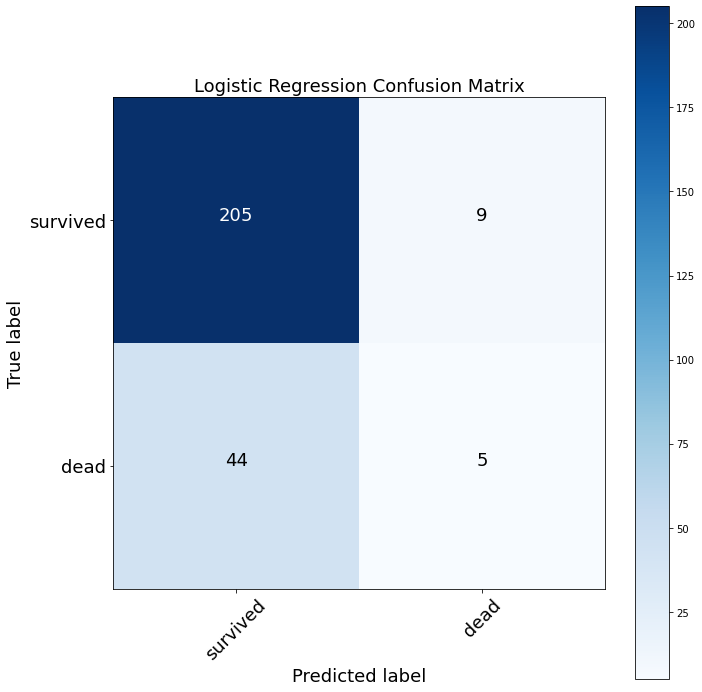

In [17]:
testidx = 1
testmodel = cali_models[testidx]
testX = pd.read_csv(os.path.join(cdiff_dir, "./fullX_test_"+str(testidx)+".csv"))[features]
testy = pd.read_csv(os.path.join(cdiff_dir, "./fully_test_"+str(testidx)+".csv"), header=None)
evaluate_model(testmodel, testX.values, testy.values, model_name="Logistic Regression")

In [18]:
fullX_test.shape

(263, 29)

In [19]:
fullX_train.shape

(1052, 29)

Thresholds: 0.34
Accuracy: 81.37%
AUROC: 0.71
Sensitivity: 18.18%
Specificity: 98.08%
PPV: 71.43%
NPV: 81.93%


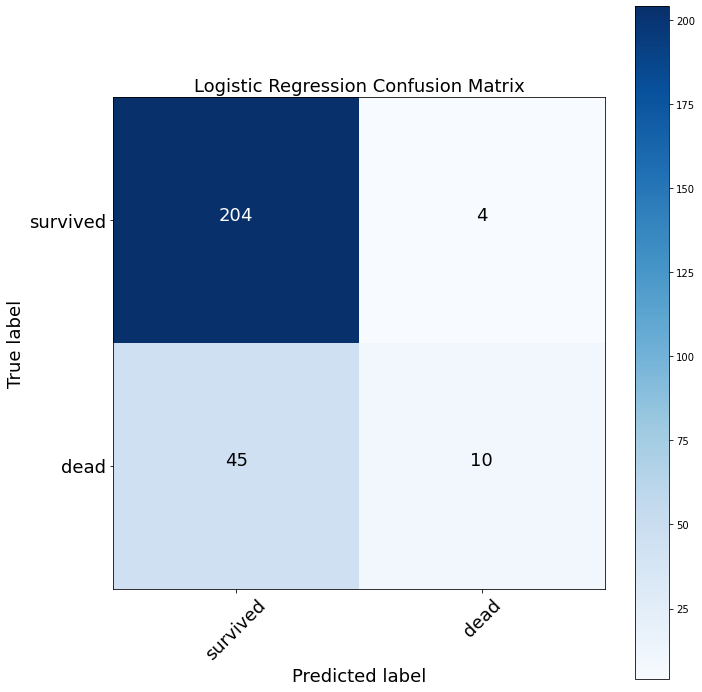

In [24]:
evaluate_model(cali_models[-1], fullX_test.values, fully_test.values, model_name="Logistic Regression")

In [67]:
with open("/data/volume02/CDAI/LR/scores.pkl", 'rb') as f:
    check = pickle.load(f)

In [69]:
len(check)

100

In [46]:
np.array(aucs).mean()

0.6912170542635659

In [2]:
logit_model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                 intercept_scaling=1, l1_ratio=None, max_iter=1000,
                                 multi_class='auto', n_jobs=16, penalty='l2',
                                 random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                                 warm_start=False)